# Hospital Stay Predictions

This notebook uses hospital patient records to predict the length of a patients stay at time of admission. It is possible to have multiple records per patient

The notebook is layed out as follows:

1. Data Exploration & Preparation
2. Diagnostic analysis
3. Predictive analysis
4. Prescriptive analysis
5. Transparency & explainability

## 1. Data Exploration & Preparation

In this section the data set is cleaned and its format prepared for processing.

In [209]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from helpers.plots import *
import os

#### Load data

In [149]:
# Get data path
DIR = os.getcwd() # current working directory
DATA_PATH = os.path.join(DIR,"data","hospital_stay_data.csv")

# Load data
df = pd.read_csv(DATA_PATH)

#### Data Preview

In [150]:
num_records = df.shape[0]

print(f"Number of Features: {df.shape[1]}")
print(f"Number of Records : {num_records}")
print("Data preview: \n")
df.head()

Number of Features: 18
Number of Records : 318438
Data preview: 



,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


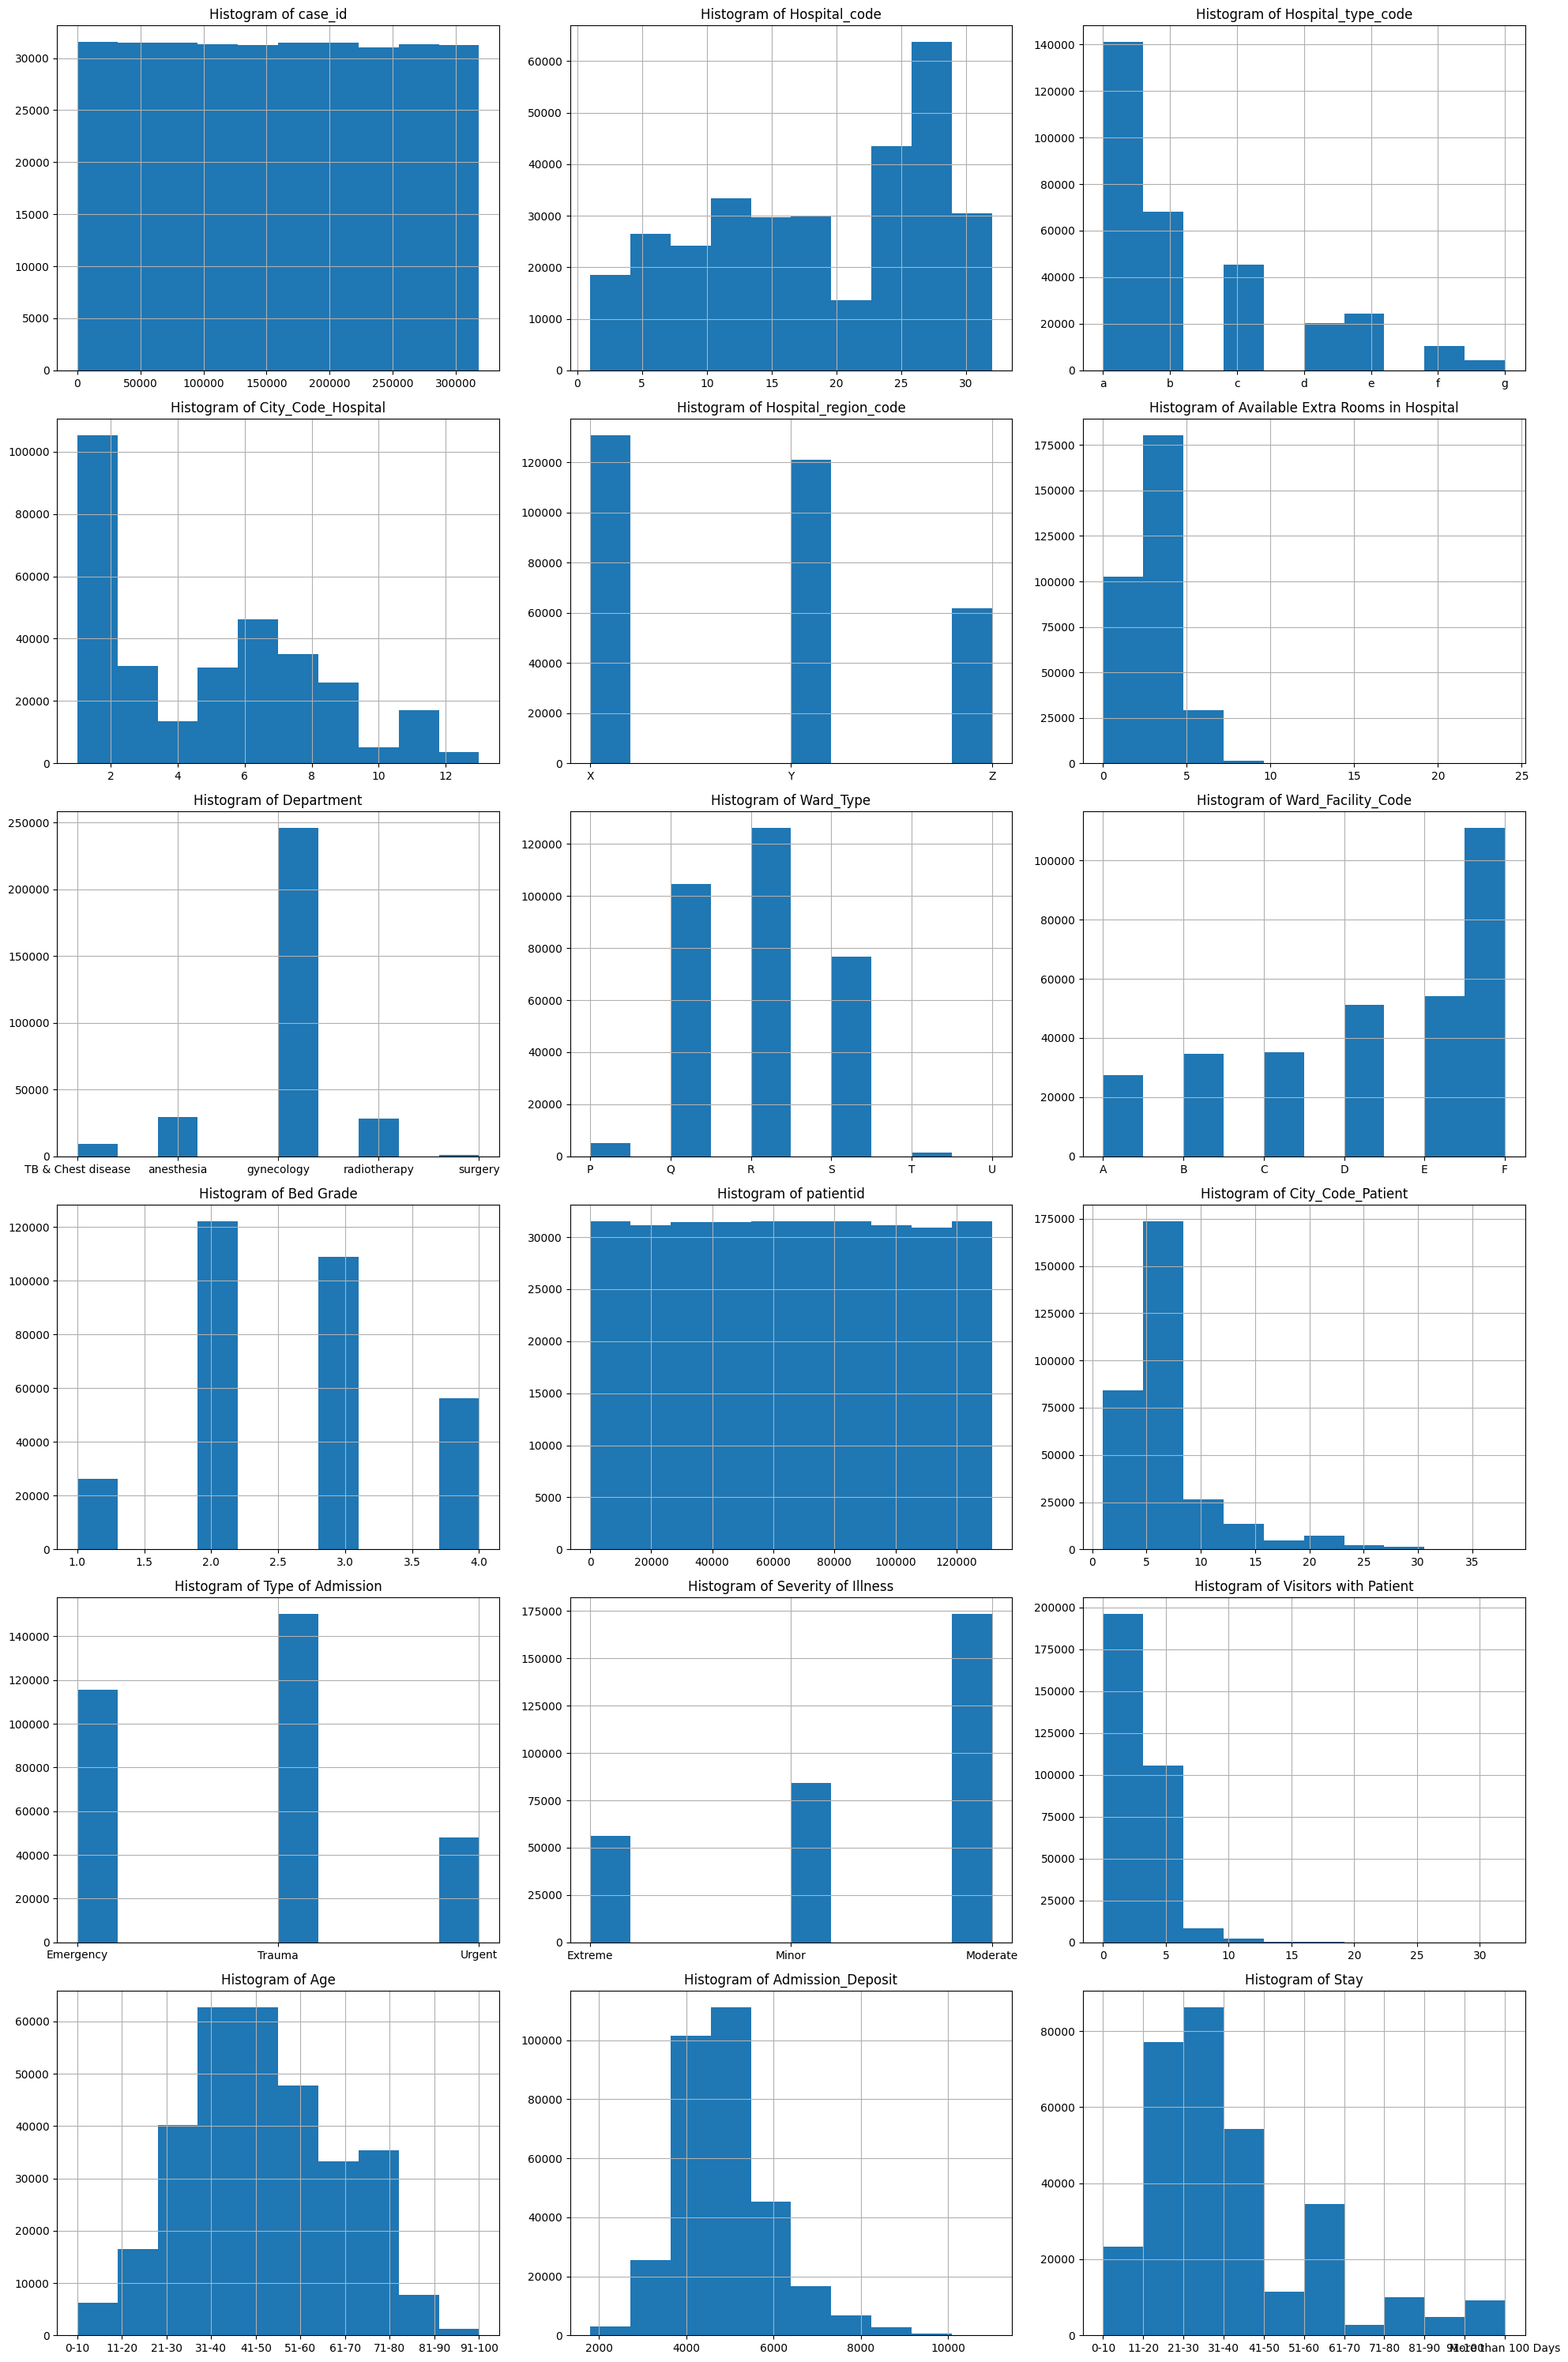

In [211]:
# View histogram of data
plot_histograms(df,3)

In [151]:
# Check contiuous variable types are correct
cont_features = ["Bed Grade", "City_Code_Patient"]
for feature in cont_features:
    diff = np.sum(df[feature] - np.floor(df[feature]))
    if diff == 0:
        print(f"- {feature}: integer values" )
    else: 
        print(f"- {feature}: continuous values" )

- Bed Grade: integer values
- City_Code_Patient: integer values


#### Data Cleaning & Handling Missing Data

In [152]:
# Create lists based on column types
index = "case_id" # unique record identifier 
drop_cols = ["patientid"] # columns to remove 
cont_cols = ["Admission_Deposit"] # columns with continuous vars
int_cols  = ["Available Extra Rooms in Hospital", "Bed Grade", "City_Code_Patient", "Visitors with Patient"] # columns with integer vars
ord_cols  = ["Severity of Illness", "Age", "Stay"] # columns with ordinal categorical vars
nom_cols  = ["Hospital_code", "Hospital_type_code", "City_Code_Hospital", "Hospital_region_code", "Department", "Ward_Type", "Ward_Facility_Code", "Type of Admission"] # columns with nominal categorical vars --> dummy encoding (ensure not too many categories)

In [153]:
# Reset index
df.set_index(index)

# Check for Nan values 
print("Columns containing Nan values: ", [i for i in df.columns if df[i].isna().any()])

Columns containing Nan values:  ['Bed Grade', 'City_Code_Patient']


In [154]:
# Fill City_Code_Patient using another existing record for that patient
City_Code_Patient_dict = df[["patientid","City_Code_Patient"]].dropna().drop_duplicates(inplace=False).set_index("patientid").to_dict() # dict of patient id and their city codes

for i in range(df.shape[0]): # for each row of data
    if np.isnan(df.iloc[i]["City_Code_Patient"]) and df.iloc[i]["patientid"] in City_Code_Patient_dict.keys(): #if the city code is missing and their is another patient record to fill from
        df.iloc[i]["City_Code_Patient"] = City_Code_Patient_dict[df.iloc[i]["patientid"]]


# Drop records with empty values
df.dropna(inplace=True)
print("Columns containing Nan values: ", [i for i in df.columns if df[i].isna().any()])  

Columns containing Nan values:  []


In [155]:
# Drop unnecessary columns
df_clean = df.drop(drop_cols, axis=1).set_index(index)
clean_shape = df_clean.shape

# Correct variable types
for col in cont_cols:
    df_clean[col] = df_clean[col].astype(float) #ensure continuous vars are floats 
for col in int_cols:
    df_clean[col] = df_clean[col].astype(int) #ensure discrete vars are ints
for col in nom_cols:
    df_clean[col] = df_clean[col].astype(str) #ensure nominal vars are strings
    
df_clean.dtypes

Hospital_code                         object
Hospital_type_code                    object
City_Code_Hospital                    object
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                              int64
City_Code_Patient                      int64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

#### Data Encoding - Ordinal


In [177]:
# Check number of unique categories
print("Ordinal features and their cardinality")
for ord in ord_cols:
    print("\t -",ord, df_clean[ord].nunique())

Ordinal features and their cardinality
	 - Severity of Illness 3
	 - Age 10
	 - Stay 11


In [ ]:
# Encode severity of illness
sev_mapping = {'Minor':0, 'Moderate':1, 'Extreme':2} #set ordering
df_clean["Severity of Illness"] = df_clean["Severity of Illness"].replace(sev_mapping)
    
# Encode age
age_enc = LabelEncoder()
df_clean["Age"] = age_enc.fit_transform(df_clean["Age"])
    
# Encode age
stay_enc = LabelEncoder()
df_clean["Stay"] = stay_enc.fit_transform(df_clean["Stay"])

# Print encodings 
print(df_clean[ord_cols])
print(df[ord_cols])

         Severity of Illness  Age  Stay
case_id                                
1                          2    5     0
2                          2    5     4
3                          2    5     3
4                          2    5     4
5                          2    5     4
...                      ...  ...   ...
318434                     1    4     1
318435                     1    8     3
318436                     0    7     1
318437                     0    1     1
318438                     0    1     0

[313793 rows x 3 columns]
       Severity of Illness    Age   Stay
0                  Extreme  51-60   0-10
1                  Extreme  51-60  41-50
2                  Extreme  51-60  31-40
3                  Extreme  51-60  41-50
4                  Extreme  51-60  41-50
...                    ...    ...    ...
318433            Moderate  41-50  11-20
318434            Moderate  81-90  31-40
318435               Minor  71-80  11-20
318436               Minor  11-20  11-20
31

C:\Users\sian_\AppData\Local\Temp\ipykernel_13764\2692914773.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["Severity of Illness"] = df_clean["Severity of Illness"].replace(sev_mapping)


#### Data Encoding - Nominal

In [158]:
print("Nominal features and their cardinality")
for nom in nom_cols:
    print("\t -",nom, df_clean[nom].nunique())

Nominal features and their cardinality
	 - Hospital_code 32
	 - Hospital_type_code 7
	 - City_Code_Hospital 11
	 - Hospital_region_code 3
	 - Department 5
	 - Ward_Type 6
	 - Ward_Facility_Code 6
	 - Type of Admission 3


In [ ]:
# Use binary encodings to represent nominal data
enc = ce.BinaryEncoder(cols=nom_cols)
enc_cols = enc.fit_transform(df_clean[nom_cols])

# Append encoded nominal data to dataframe
df_enc = pd.concat([df_clean, enc_cols], axis=1,join='inner')

# Drop non-encoded columns
df_enc.drop(nom_cols, axis=1, inplace=True)

# Check dimensions are correct
assert df_enc.shape[0] == clean_shape[0] #check rows
assert df_enc.shape[1] > clean_shape[1] #check cols

#### Cleaning up column names

In [202]:
#Tidy column names
df_enc.columns = df_enc.columns.str.strip().str.lower().str.replace(' ', '_')
df_enc.columns = df_enc.columns.str.replace('department', 'dpt')
df_enc.columns = df_enc.columns.str.replace('of_', '')
df_enc.columns = df_enc.columns.str.replace('in_', '')
df_enc.columns = df_enc.columns.str.replace('extra_', '')
df_enc.columns = df_enc.columns.str.replace('available', 'avail')

# View columns of dataframe
print(list(df_enc.columns))

['avail_rooms_hospital', 'bed_grade', 'city_code_patient', 'severity_illness', 'visitors_with_patient', 'age', 'admission_deposit', 'stay', 'hospital_code_0', 'hospital_code_1', 'hospital_code_2', 'hospital_code_3', 'hospital_code_4', 'hospital_code_5', 'hospital_type_code_0', 'hospital_type_code_1', 'hospital_type_code_2', 'city_code_hospital_0', 'city_code_hospital_1', 'city_code_hospital_2', 'city_code_hospital_3', 'hospital_region_code_0', 'hospital_region_code_1', 'dpt_0', 'dpt_1', 'dpt_2', 'ward_type_0', 'ward_type_1', 'ward_type_2', 'ward_facility_code_0', 'ward_facility_code_1', 'ward_facility_code_2', 'type_admission_0', 'type_admission_1']


#### Check data loss due to cleaning

In [194]:
# Assess data loss due to cleaning
print(f"After cleaning {round(df_enc.shape[0]*100/num_records,1)}% of the data remains")

After cleaning 98.5% of the data remains


## 2. Diagnostic Analysis

#### Correlation Analysis

1. **Spearman Rank Order Correlation**
is used as it can assess the relationship between the features and the target variable "Stay". It was chosen because:
    - does not assume normally distributed data ( is non-parametric)
    - can be applied to continuous and ordinal data
    - assumptions:
        - monotonic relationship between variables

1. **Cramer's V**
is used to determine the strength of relationship between 2 categorical variables. It uses the Chi^2 statistic to produce a normalised coeffecient in (0,1) which allows for comparison across the entrie table.
    - applicable to tables  bigger than 2x2
    - compares categorical data
    - assumptions:
        - mutually exclusive levels or categories
        - frequency in each cell is at least 5 in 80% of cells

#### Continuous & Ordinal Correlation

In [219]:
from helpers.plots import plot_scatters
## Check for monotonic relationships
plot_scatters(df[cont_cols+ord_cols],3,target="Stay")

ImportError: cannot import name 'plot_scatters' from 'helpers.plots' (c:\Users\sian_\OneDrive\Documents\Career\2025\Cluepoints\ML-Case\helpers\plots.py)

## 3. Predictive Analysis

## 4. Prescriptive Analysis

## 5. Transparency & Explainability